jackknife.ipynb

Calculates the excess surface density for a specific lens/source bin pair and includes jackknife uncertainty estimation.

At the bottom of the notebook, there is a rudimentary attempt at my own jackknife estimation, though I stuck with the native treecorr estimator.

# Using treecorr's native jackknife:

In [1]:
import sys
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio

from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0 = 100, Om0 = 0.3, Ode0 = 0.7)

plt.rcParams.update({
    'font.family'      :'serif',
    'font.size'        : 24,
    'font.serif'       :'Georgia',
    'axes.labelsize'   :'large',
    'mathtext.fontset' :'stix',
    'axes.linewidth'   :  1.5,
    'xtick.direction'  :'in',
    'ytick.direction'  :'in',
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
})

import treecorr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
######
### Define which bins to use
lens_bin = 1
srce_bin = 3

In [3]:
correction_m_array = [-0.009, -0.011, -0.015, 0.002, 0.007]

def degree_to_hMpc(degree, redshift):
    radian = (degree * u.degree).to(u.radian)
    angular_dist_Mpc = cosmo.angular_diameter_distance(redshift)
    hMpc = angular_dist_Mpc * radian
    # comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    # hMpc = comoving_dist_Mpc * np.tan(radian)
    return hMpc

def hMpc_to_degree(hMpc, redshift):
    angular_dist_Mpc = cosmo.angular_diameter_distance(redshift).value
    radian = hMpc/angular_dist_Mpc
    # comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    # radian = np.arctan(hMpc/comoving_dist_Mpc)
    degree = (radian * u.radian).to(u.degree)
    return degree.value

In [11]:
######
###  Import & define catalogs

# lens_bin_directory = '/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_dwarf_galaxy_candidates'
lens_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/KiDS_dwarf_galaxy_candidates_09Aug24_photom'
srce_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/sources/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat'

# lens_n_z_directory = '/data2/lsajkov/mpdg/data_products/KiDS/WL/n_z'
lens_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/n_z_20p5_09Aug24'
srce_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/KiDS_SOM_N_of_Z'
# Lens catalog
lens_catalog_path = f'{lens_bin_directory}/KiDS_dwarf_galaxy_bin{lens_bin}.fits'

lens_ra  = fitsio.read(lens_catalog_path, columns = ['ra'])
lens_dec = fitsio.read(lens_catalog_path, columns = ['dec'])
number_of_lenses = len(lens_ra)

lens_catalog = treecorr.Catalog(ra = lens_ra, dec = lens_dec, npatch = number_of_lenses//n_per_patch,
                                ra_units = 'degrees', dec_units = 'degrees')
print('Loaded lens catalog')

lens_n_z_path = f'{lens_n_z_directory}/n_z_bin{lens_bin}'
lens_n_z_array = ascii.read(lens_n_z_path)

# Source catalog
srce_catalog_path = f'{srce_bin_directory}/KiDS_DR4.1_WL_bin{srce_bin}.fits'

srce_ra      = fitsio.read(srce_catalog_path, columns = ['RAJ2000'],  ext = 1)
srce_dec     = fitsio.read(srce_catalog_path, columns = ['DECJ2000'], ext = 1)
srce_g1      = fitsio.read(srce_catalog_path, columns = ['e1'],       ext = 1)
srce_g2      = fitsio.read(srce_catalog_path, columns = ['e2'],       ext = 1)
srce_weights = fitsio.read(srce_catalog_path, columns = ['weight'],   ext = 1)

srce_catalog = treecorr.Catalog(ra = srce_ra, dec = srce_dec,
                                ra_units = 'degrees', dec_units = 'degrees',
                                g1 = srce_g1, g2 = srce_g2,
                                w  = srce_weights)
print('Loaded source catalog')

srce_n_z_path = f'{srce_n_z_directory}/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO{srce_bin}_Nz.asc'
srce_n_z_array = ascii.read(srce_n_z_path)

Loaded lens catalog
Loaded source catalog


In [12]:
######
### Define bins
lens_n_z_expected = np.dot(lens_n_z_array['col0'], lens_n_z_array['col1'] * lens_n_z_array['col0'][1] - lens_n_z_array['col0'][0])

log10_hMpc_bin_lo = -2
log10_hMpc_bin_hi = 1
bins = 15
hMpc_bins = np.logspace(log10_hMpc_bin_lo, log10_hMpc_bin_hi, bins)

degree_bins = hMpc_to_degree(hMpc_bins, lens_n_z_expected)

In [13]:
######
### Define treecorr config
n_per_patch = 100

config = {'nbins':     bins,
          'min_sep':   degree_bins[0],
          'max_sep':   degree_bins[-1],
          'sep_units': 'degree',
          'npatch': number_of_lenses//n_per_patch,
          'var_method': 'jackknife'}
 
print(f'Number of lenses: {number_of_lenses}\n\t patches: {number_of_lenses//n_per_patch}\nLenses per patch: {number_of_lenses/(number_of_lenses//n_per_patch):.2f}')

Number of lenses: 26787
	 patches: 267
Lenses per patch: 100.33


In [14]:
######
### Calculate shear correlation

ngc = treecorr.NGCorrelation(config = config)
ngc.process(lens_catalog, srce_catalog)

In [15]:
######
### Calculate average surface critical density

G_in_pc_msun_s = const.G.to(u.parsec**3/(u.Msun * u.s**2))
c_in_pc_s      = const.c.to(u.parsec/u.s)

constant_factor = 4 * np.pi * G_in_pc_msun_s / (c_in_pc_s**2)

In [16]:
#lens integral

lens_redshifts     = lens_n_z_array['col0']
lens_dz            = lens_redshifts[1] - lens_redshifts[0] #the redshift bins are linear, all deltas are the same
lens_ang_diam_dist = cosmo.angular_diameter_distance(lens_redshifts).to(u.parsec)
lens_n_z           = lens_n_z_array['col1']
lens_n_z          /= np.sum(lens_n_z * lens_dz) #normalize n(z) so it integrates to 1
print(f'Lens n(z) integrates to {np.sum(lens_n_z * lens_dz):.2f}')

lens_integral = np.sum(lens_n_z * (1 + lens_redshifts)**2 * lens_ang_diam_dist * lens_dz)

#source integral
behind_lens_idx = srce_n_z_array['col1'] > lens_n_z_expected

srce_redshifts = srce_n_z_array[behind_lens_idx]['col1']
srce_dz        = srce_redshifts[1] - srce_redshifts[0] #the redshift bins are linear, all deltas are the same
srce_ang_diam_dist = cosmo.angular_diameter_distance(srce_redshifts).to(u.parsec)
srce_ang_diam_dist_w_lens = cosmo.angular_diameter_distance_z1z2(lens_n_z_expected, srce_redshifts).to(u.parsec)
srce_n_z = srce_n_z_array[behind_lens_idx]['col2']
srce_n_z /= np.sum(srce_n_z * lens_dz)
print(f'Source n(z) integrates to {np.sum(srce_n_z * lens_dz):.2f}')

srce_integral = np.sum(srce_n_z * srce_ang_diam_dist_w_lens / srce_ang_diam_dist * srce_dz)

#total integral
avg_sigma_crit = constant_factor * lens_integral * srce_integral
print(f'Units of average critical density: {avg_sigma_crit.unit}')

Lens n(z) integrates to 1.00
Source n(z) integrates to 1.00
Units of average critical density: pc2 / solMass


In [17]:
######
### Get excess surface density

shear_correlation_real = ngc.xi
shear_correlation_imag = ngc.xi_im

shear_correlation_covar = ngc.varxi

correction_m = correction_m_array[int(srce_bin) - 1]

excess_surf_density = shear_correlation_real/(1 + correction_m)/avg_sigma_crit

print(f'Final unit of excess surface density: {excess_surf_density.unit}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Final unit of excess surface density: solMass / pc2


In [ ]:
save_results_directory = '/Users/leo/Projects/mass_profile_dg/data_products/WL/WL_excess_surf_density_results/17Oct24_jackknife'

final_results = Table([np.round(degree_bins, 3),
                       np.round(hMpc_bins, 3),
                       np.round(shear_correlation_real, 6),
                       np.round(shear_correlation_imag, 6),
                       np.round(shear_correlation_covar, 6),
                       np.round(excess_surf_density.value, 3),
                       np.round([avg_sigma_crit.value] * len(degree_bins), 3)],
               names = ['R[degrees]',
                        'R[h-1 Mpc]',
                        'gamma_T_real',
                        'gamma_T_imag',
                        'gamma_T_covar',
                        'deltaSigma[h Msun pc-2]',
                        'averageSigmaCrit[pc2 Msun-1]'])
ascii.write(final_results, f'{save_results_directory}/output_lensbin{lens_bin}_srcebin{srce_bin}.dat',
            overwrite = True)

# save_results_directory = '/data2/lsajkov/mpdg/data_products/WL_excess_surf_density_results/02Aug24'
# ascii.write(final_results.transpose(), f'{save_results_directory}/output_lensbin{lens_bin}_srcebin{srce_bin}.dat',
#             overwrite = False)

# Troubleshoot

In [1]:
# Measure excess surface density for a lens bin/source bin pair.
import sys
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio

from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0 = 100, Om0 = 0.3, Ode0 = 0.7)


import treecorr

""" KiDS SOM-derived lens tomographic bins.
  | Bin | <z>  | <Mstar> |
  | 1   | 0.07 |  8.58   |
  | 2   | 0.09 |  9.20   |
  | 3   | 0.16 |  9.92   | NOT used in this analysis

"""

""" KiDS-1000 source tomographic bins. Drawn from Giblin et al. (2020):
  | Bin |   z_B range   |        m        |
  | 1   |   0.1<z<0.3   | -0.009 pm 0.019 |
  | 2   |   0.3<z<0.5   | -0.011 pm 0.020 |
  | 3   |   0.5<z<0.7   | -0.015 pm 0.017 |
  | 4   |   0.7<z<0.9   |  0.002 pm 0.012 |
  | 5   |   0.9<z<1.2   |  0.007 pm 0.010 |
"""

correction_m_array = [-0.009, -0.011, -0.015, 0.002, 0.007]

def degree_to_hMpc(degree, redshift):
    radian = (degree * u.degree).to(u.radian)
    angular_dist_Mpc = cosmo.angular_diameter_distance(redshift).value
    hMpc = angular_dist_Mpc * radian
    return hMpc

def hMpc_to_degree(hMpc, redshift):
    angular_dist_Mpc = cosmo.angular_diameter_distance(redshift).value
    radian = hMpc/angular_dist_Mpc
    degree = (radian * u.radian).to(u.degree)
    return degree.value

def median(x, p_x):
    dx = x[1] - x[0]

    cdf = np.array([np.sum(dx * p_x[:i]) for i in range(len(x))])
    cdf_half = cdf <= 1/2

    approx_median = x[cdf_half][-1]

    return approx_median 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
######
###  Import & define catalogs

lens_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/KiDS_dwarf_galaxy_candidates_09Aug24_photom'
srce_bin_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/sources/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat'

lens_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/n_z_20p5_09Aug24'
srce_n_z_directory = '/Users/leo/Projects/mass_profile_dg/data_WL/KiDS_SOM_N_of_Z'

lens_bin = 1
srce_bin = 3
bins = 10
sources_per_patch = 25
covar_method = 'jk'
save_results_directory = '/Users/leo/Projects/mass_profile_dg/data_products/WL/WL_excess_surf_density_results/17Oct24_jackknife'


# Lens catalog
lens_catalog_path = f'{lens_bin_directory}/KiDS_dwarf_galaxy_bin{lens_bin}.fits'

lens_ra  = fitsio.read(lens_catalog_path, columns = ['ra'])
lens_dec = fitsio.read(lens_catalog_path, columns = ['dec'])
number_of_lenses = len(lens_ra)

lens_catalog = treecorr.Catalog(ra = lens_ra, dec = lens_dec,
                                ra_units = 'degrees', dec_units = 'degrees')
print('Loaded lens catalog')

lens_n_z_path = f'{lens_n_z_directory}/n_z_bin{lens_bin}'
lens_n_z_array = ascii.read(lens_n_z_path)

# Source catalog
srce_catalog_path = f'{srce_bin_directory}/KiDS_DR4.1_WL_bin{srce_bin}.fits'

srce_ra      = fitsio.read(srce_catalog_path, columns = ['RAJ2000'],  ext = 1)
srce_dec     = fitsio.read(srce_catalog_path, columns = ['DECJ2000'], ext = 1)
srce_g1      = fitsio.read(srce_catalog_path, columns = ['e1'],       ext = 1)
srce_g2      = fitsio.read(srce_catalog_path, columns = ['e2'],       ext = 1)
srce_weights = fitsio.read(srce_catalog_path, columns = ['weight'],   ext = 1)

srce_catalog = treecorr.Catalog(ra = srce_ra, dec = srce_dec,
                                ra_units = 'degrees', dec_units = 'degrees',
                                g1 = srce_g1, g2 = srce_g2,
                                w  = srce_weights)
print('Loaded source catalog')

srce_n_z_path = f'{srce_n_z_directory}/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO{srce_bin}_Nz.asc'
srce_n_z_array = ascii.read(srce_n_z_path)

Loaded lens catalog
Loaded source catalog


In [3]:
######
### Define bins
lens_n_z_median = median(lens_n_z_array['col0'], lens_n_z_array['col1'])
# lens_n_z_expected = np.dot(lens_n_z_array['col0'], lens_n_z_array['col1'])

log10_hMpc_bin_lo = -2
log10_hMpc_bin_hi = 1
# bins = int(sys.argv[3])
hMpc_bins = np.logspace(log10_hMpc_bin_lo, log10_hMpc_bin_hi, bins)

degree_bins = hMpc_to_degree(hMpc_bins, lens_n_z_median)

In [4]:
######
### Define treecorr config

print(f'Number of lenses: {number_of_lenses}\n\t patches: {number_of_lenses//sources_per_patch}\nLenses per patch: {number_of_lenses/(number_of_lenses//sources_per_patch):.2f}')

if (sources_per_patch != 0) & (covar_method in ['jackknife', 'jk']):
  print('Covariance estimator: jackknife')
  config = {'nbins':     bins,
            'min_sep':   degree_bins[0],
            'max_sep':   degree_bins[-1],
            'npatch':  number_of_lenses//sources_per_patch,
            'sep_units': 'degree',
            'var_method': 'jackknife'}

elif covar_method in ['', 'covar']:
  print('Covariance estimator: shot-noise')
  config = {'nbins':     bins,
            'min_sep':   degree_bins[0],
            'max_sep':   degree_bins[-1],
            'sep_units': 'degree'}

Number of lenses: 26787
	 patches: 1071
Lenses per patch: 25.01
Covariance estimator: jackknife


In [5]:
######
### Calculate shear correlation

print(config['var_method'], config['npatch'])
ngc = treecorr.NGCorrelation(config = config)
ngc.process(lens_catalog, srce_catalog)

jackknife 1071


In [6]:
######
### Calculate average surface critical density

G_in_pc_msun_s = const.G.to(u.parsec**3/(u.Msun * u.s**2))
c_in_pc_s      = const.c.to(u.parsec/u.s)

constant_factor = 4 * np.pi * G_in_pc_msun_s / (c_in_pc_s**2)

#lens integral
lens_redshifts     = lens_n_z_array['col0']
lens_dz            = lens_redshifts[1] - lens_redshifts[0] #the redshift bins are linear, all deltas are the same
lens_ang_diam_dist = cosmo.angular_diameter_distance(lens_redshifts).to(u.parsec)
lens_n_z           = lens_n_z_array['col1']
lens_n_z          /= np.sum(lens_n_z * lens_dz) #normalize n(z) so it integrates to 1
print(f'Lens n(z) integrates to {np.sum(lens_n_z * lens_dz):.2f}')

lens_integral = np.sum(lens_n_z * (1 + lens_redshifts)**2 * lens_ang_diam_dist * lens_dz)

#source integral
behind_lens_idx = srce_n_z_array['col1'] > lens_n_z_median

srce_redshifts = srce_n_z_array[behind_lens_idx]['col1']
srce_dz        = srce_redshifts[1] - srce_redshifts[0] #the redshift bins are linear, all deltas are the same
srce_ang_diam_dist = cosmo.angular_diameter_distance(srce_redshifts).to(u.parsec)
srce_ang_diam_dist_w_lens = cosmo.angular_diameter_distance_z1z2(lens_n_z_median, srce_redshifts).to(u.parsec)
srce_n_z = srce_n_z_array[behind_lens_idx]['col2']
srce_n_z /= np.sum(srce_n_z * lens_dz)
print(f'Source n(z) integrates to {np.sum(srce_n_z * lens_dz):.2f}')

srce_integral = np.sum(srce_n_z * srce_ang_diam_dist_w_lens / srce_ang_diam_dist * srce_dz)

#total integral
avg_sigma_crit = constant_factor * lens_integral * srce_integral
print(f'Units of average critical density: {avg_sigma_crit.unit}')

Lens n(z) integrates to 1.00
Source n(z) integrates to 1.00
Units of average critical density: pc2 / solMass


In [7]:
######
### Get excess surface density

shear_correlation_real = ngc.xi
shear_correlation_imag = ngc.xi_im

shear_correlation_covar = ngc.varxi

correction_m = correction_m_array[int(srce_bin) - 1]

excess_surf_density = shear_correlation_real/(1 + correction_m)/avg_sigma_crit
excess_surf_density_covar = shear_correlation_covar/(1 + correction_m)/avg_sigma_crit

ValueError: Using jackknife covariance requires using patches.

In [ ]:
# save_results_directory = '/Users/leo/Projects/mass_profile_dg/data_products/WL/WL_excess_surf_density_results/17Oct24_jackknife'

final_results = Table([np.round(degree_bins, 3),
                       np.round(hMpc_bins, 3),
                       np.round(shear_correlation_real, 6),
                       np.round(shear_correlation_imag, 6),
                       np.round(shear_correlation_covar, 6),
                       np.round(excess_surf_density.value, 6),  
                       np.round(excess_surf_density_covar.value, 6),
                       np.round([avg_sigma_crit.value] * len(degree_bins), 3)],
               names = ['R[degrees]',
                        'R[h-1 Mpc]',
                        'gamma_T_real',
                        'gamma_T_imag',
                        'gamma_T_covar',
                        'deltaSigma[h Msun pc-2]',
                        'covar_deltaSigma[h Msun pc-2]',
                        'averageSigmaCrit[pc2 Msun-1]'])

ascii.write(final_results, f'{save_results_directory}/output_lensbin{lens_bin}_srcebin{srce_bin}.dat',
            overwrite = True)

print(f'Final unit of excess surface density: {excess_surf_density.unit}')

# Attempt at my own:

In [24]:
import numpy as np
from fitsio import FITS

import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0 = 70, Om0 = 0.3, Ode0 = 0.7)

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('mpdg.mplstyle')

In [19]:
def ra_shift(array): #input array of values in degrees

    multiplicative_factors = np.floor(array / 180)
    shifted_array = array - multiplicative_factors * 360

    return shifted_array

In [20]:
lenses_bin1_path = '/Users/leo/Projects/mass_profile_dg/data_WL/lenses/KiDS_dwarf_galaxy_candidates_09Aug24_photom/KiDS_dwarf_galaxy_bin1.fits'
lenses_bin1 = FITS(lenses_bin1_path)[1]

In [21]:
sources_bin1_path = '/Users/leo/Projects/mass_profile_dg/data_WL/sources/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat/KiDS_DR4.1_WL_bin1.fits'
sources_bin1 = FITS(sources_bin1_path)

In [32]:
X = np.array(list(zip(lenses_bin1['ra'][:],
                      lenses_bin1['dec'][:])))

In [35]:
KMeans(n_clusters = 10).fit(X[:100])

/opt/anaconda3/envs/astro-two/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


: 

: 

Text(0.5, 1.0, 'Lens bin 1: $\\langle M_* \\rangle < 10^{8.5} M_{\\odot}$')

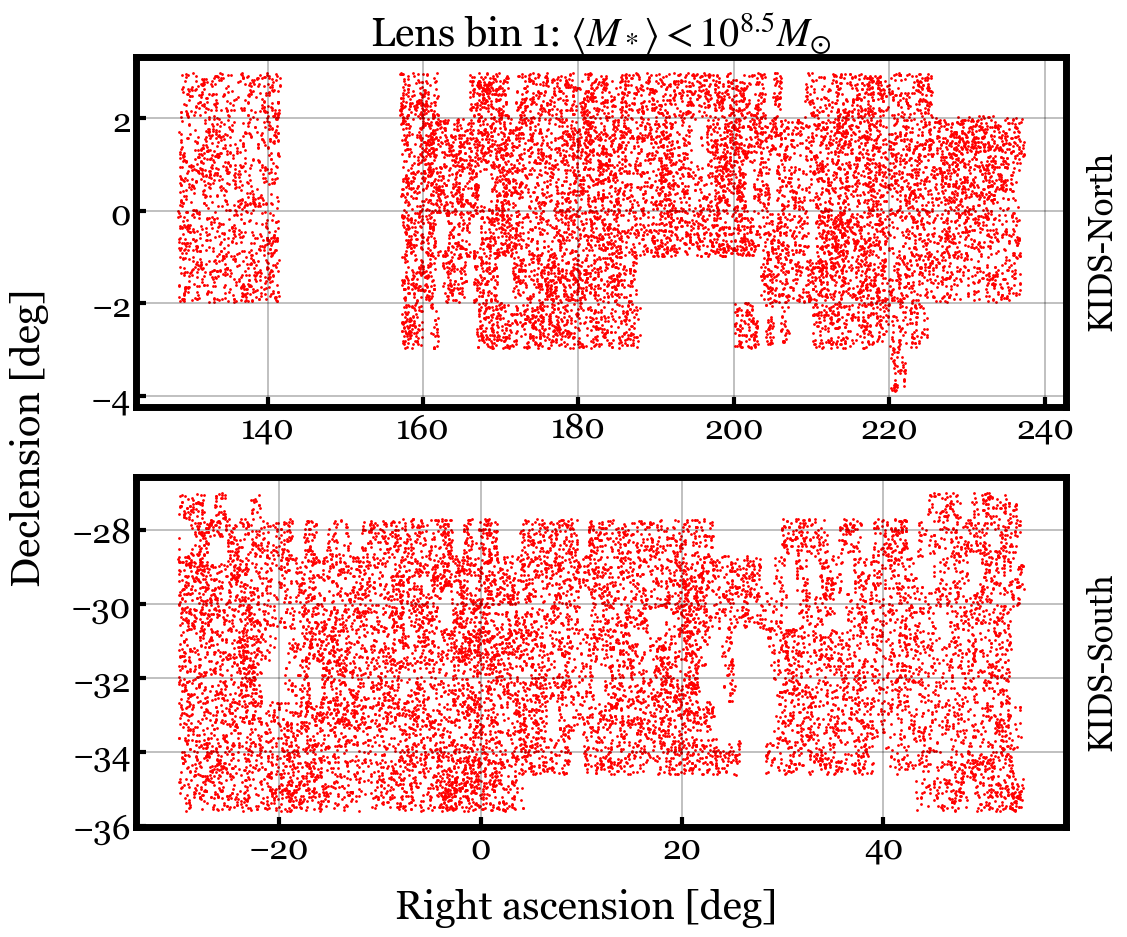

In [22]:
fig = plt.figure()
ax_t = fig.add_subplot(211)

lenses_bin1_ra = lenses_bin1['ra'][:] * u.deg
lenses_bin1_dec = lenses_bin1['dec'][:] * u.deg

field_north = lenses_bin1_dec > -10*u.deg
field_south = ~field_north

ax_t.scatter(lenses_bin1_ra[field_north], lenses_bin1_dec[field_north],
             s = 1)

ax_t.grid(color = 'black', linewidth = 0.35)

ax_t.text(1.02, 0.24, 'KIDS-North', rotation = 90,
          transform = ax_t.transAxes)

ax_b = fig.add_subplot(212)

field_south_left_of_180 = lenses_bin1_ra[field_south] < 180 * u.deg

ax_b.scatter(ra_shift(lenses_bin1_ra[field_south]), lenses_bin1_dec[field_south],
             s = 1)

ax_b.grid(color = 'black', linewidth = 0.35)

ax_b.text(1.02, 0.24, 'KIDS-South', rotation = 90,
          transform = ax_b.transAxes)

fig.supxlabel('Right ascension [deg]')
fig.supylabel('Declension [deg]')

ax_t.set_title(r'Lens bin 1: $\langle M_* \rangle < 10^{8.5} M_{\odot}$')

In [ ]:
sources_ra = sources_bin1[1]['RAJ2000'][:]
sources_dec = sources_bin1[1]['DECJ2000'][:]

In [ ]:
random_index = np.random.randint(0, lenses_bin1.get_nrows())
random_gal = [lenses_bin1_ra[random_index],
              lenses_bin1_dec[random_index]]
within_1_deg = np.sqrt((sources_ra * u.deg - random_gal[0]) ** 2 + (sources_dec * u.deg - random_gal[1]) ** 2) < 1 * u.deg

In [ ]:
fig = plt.figure()
ax_t = fig.add_subplot(211)

sources_ra = sources_bin1[1]['RAJ2000'][:]
sources_dec = sources_bin1[1]['DECJ2000'][:]

source_field_north = sources_dec > -10
ax_t.scatter(sources_ra[source_field_north & ~within_1_deg], sources_dec[source_field_north & ~within_1_deg],
             s = 1, color = 'black')
# ax_t.scatter(kids_lenses_bin1_ra_deg[field_north & ~within_1_deg], kids_lenses_bin1_dec_deg[field_north & ~within_1_deg],
#              s = 1)

ax_t.grid(color = 'black', linewidth = 0.35)

ax_t.text(1.02, 0.24, 'KIDS-North', rotation = 90,
          transform = ax_t.transAxes)

# ax_t.scatter(*random_gal, color = 'black')

# ax_t.set_xlim(125, 240)
# ax_t.set_ylim(-4.2, 3.6)

ax_b = fig.add_subplot(212)

ax_b.scatter(ra_shift(sources_ra[~source_field_north & ~within_1_deg]), sources_dec[~source_field_north & ~within_1_deg],
             s = 1, color = 'black')

# ax_b.grid(color = 'black', linewidth = 0.35)

# ax_b.text(1.02, 0.24, 'KIDS-South', rotation = 90,
#           transform = ax_b.transAxes)

# fig.supxlabel('Right ascension [deg]')
# fig.supylabel('Declension [deg]')

# ax_b.scatter(*random_gal, color = 'black')

# ax_b.set_xlim(-35, 60)
# ax_b.set_ylim(-36, -26.5)

# ax_t.set_title(r'Lens bin 1: $\langle M_* \rangle < 10^{8.5} M_{\odot}$')

### What is the average separation between lenses?

To determine the ideal size of a jackknife region

In [ ]:
delta_ras = np.array([np.sort(np.abs(lenses_bin1_ra - lenses_bin1_ra[i]))[1].value for i in range(len(lenses_bin1_ra))])
delta_decs = np.array([np.sort(np.abs(lenses_bin1_dec - lenses_bin1_dec[i]))[1].value for i in range(len(lenses_bin1_dec))])

In [ ]:
mean_sep = np.mean(np.sqrt(delta_ras ** 2 + delta_decs ** 2))

In [ ]:
mean_redshift = 0.06

In [ ]:
def degree_to_hMpc(degree, redshift):
    radian = (degree * u.degree).to(u.radian)
    comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    hMpc = comoving_dist_Mpc * np.tan(radian)
    return hMpc

def hMpc_to_degree(hMpc, redshift):
    comoving_dist_Mpc = cosmo.comoving_distance(redshift).value
    radian = np.arctan(hMpc/comoving_dist_Mpc)
    degree = (radian * u.radian).to(u.degree)
    return degree.value

In [ ]:
degree_to_hMpc(mean_sep, mean_redshift)

In [ ]:
hMpc_to_degree(10, mean_redshift)